In [1]:
import os
import sys

sys.path.append(os.path.expanduser("~/mhw_stressviz/analysis/"))
from physiology import tpc

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3

from importlib import reload
reload(tpc); 

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [3]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:45949 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Verify generated MHWs + Properties

In [9]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [10]:
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).persist()

In [6]:
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)

In [7]:
mhws = xr.open_zarr(mhw_mapper)

In [8]:
mhws

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 140, time: 13636)
Coordinates:
  * lat                   (lat) float32 30.125 30.375 30.625 ... 59.625 59.875
  * lon                   (lon) float64 -155.9 -155.6 -155.4 ... -121.4 -121.1
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
Data variables:
    clim_seas             (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    clim_thresh           (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    duration              (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    index_end             (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    index_peak            (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    index_start           (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_cumulative  (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_max         (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_mean        (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_var         (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    mhw                   (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    rate_decline          (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    rate_onset            (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>

## Make some Plots
We'll look at the 2014-2015 anomaly in the PNW

In [97]:
date_range = slice("2014-01-01", "2015-12-31")

In [98]:
mhw_pnw = mhws.sel(time=date_range)
sst_mhw_pnw = oisst_pnw.sel(time=date_range)

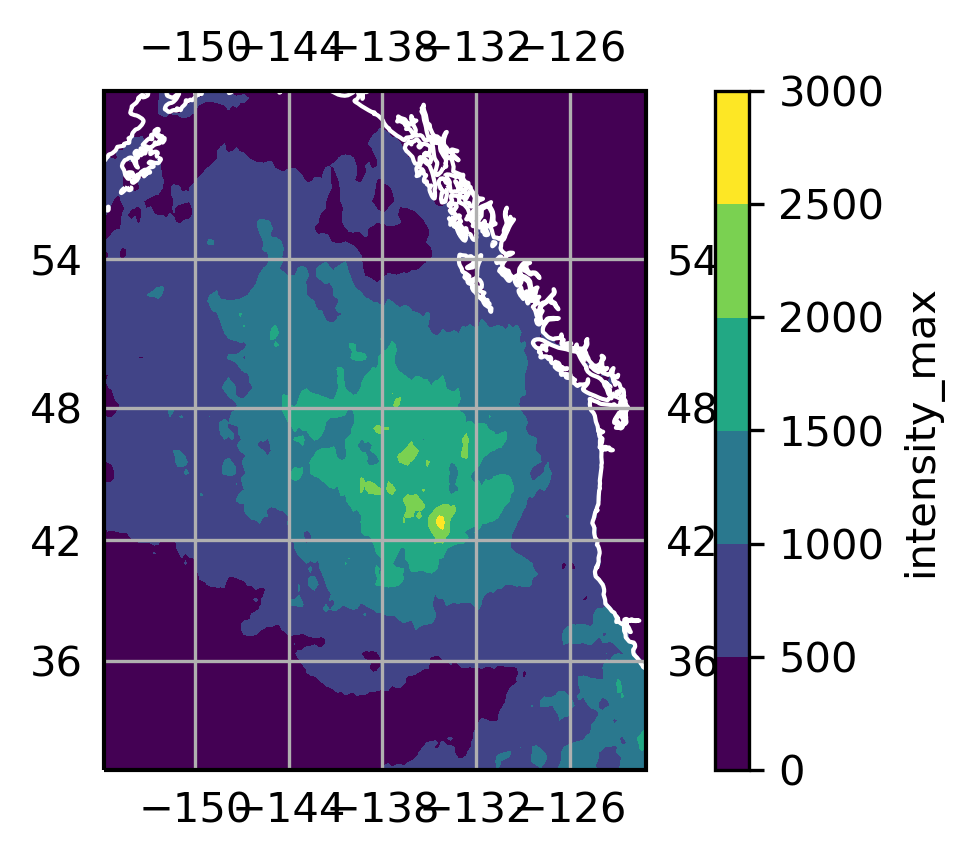

In [99]:
plt.figure(figsize=(6,3), dpi=300)
ax = plt.axes(projection=ccrs.Mercator.GOOGLE)
mhw_pnw.intensity_max.sum(dim='time').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cf.NaturalEarthFeature('physical','coastline', '50m'), facecolor='none', edgecolor='white')
ax.gridlines(draw_labels=True)

In [100]:
specific_loc = {'lat': -134., "lon": 45.0}


In [101]:
starts = np.unique(mhw_pnw.sel(**specific_loc, method='nearest').index_start.values)
ends = np.unique(mhw_pnw.sel(**specific_loc, method='nearest').index_end.values)
events = np.array(list(itertools.zip_longest(starts, ends, fillvalue=np.nan)))

In [102]:
sorted_events = np.diff(events, axis=1).argsort(axis=0)[::-1]

In [103]:
longest_event = events[np.diff(events, axis=1).argsort()[::-1][0]]

In [104]:
this_event = int(sorted_events[1].squeeze())

In [105]:
startdate_actual = mhws.time[events[this_event][0].astype('int')]
enddate_actual =  mhws.time[events[this_event][1].astype('int')]

In [106]:
startdate = mhws.time[events[this_event][0].astype('int')] - np.timedelta64(90, 'D')
enddate = mhws.time[events[this_event][1].astype('int')] + np.timedelta64(90, 'D')

In [107]:
this_region = mhw_pnw.sel(**specific_loc, method='nearest')
this_region_sst = oisst_pnw.sel(
    time=slice(startdate, enddate), 
    lat=slice(this_region.lat.min(), this_region.lat.max()), 
    lon=slice(this_region.lon.min(), this_region.lon.max())
)


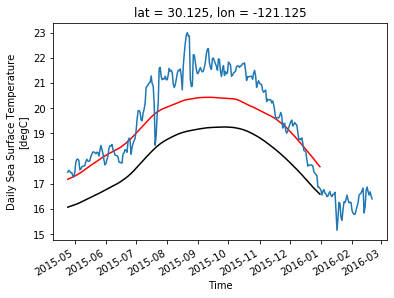

In [110]:
this_region.clim_seas.sel(time=slice(startdate, enddate)).plot(color='k')
this_region.clim_thresh.sel(time=slice(startdate, enddate)).plot(color='r')

oisst_pnw.sel(time=slice(startdate, enddate), lat=slice(this_region.lat.min(), this_region.lat.max()))
this_region_sst.sst.plot()

## Appendix: bring in phyto

In [111]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

In [112]:
plankton.habitat.unique()

array(['marine', 'saline lake', 'freshwater', 'estuarine', 'hot spring',
       'salt marsh', 'unknown'], dtype=object)

In [113]:
plankton = plankton[
    (plankton.curvequal == 'good') &
    (plankton.habitat.isin([
        'marine',
    ]))
]
len(plankton)

96

In [114]:
plankton['latqbin'] = pd.qcut(plankton['isolation.latitude'], q=10)

In [115]:
this_phyla = plankton[plankton.latqbin.isin([this_region.lat.values])]

In [116]:
this_phyla

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis,latqbin
75,94,Sargasso Sea (120m depth),28.98,-64.35,marine,Prochlorococcus marinus strain SS120,Prochlorococcus marinus,NaN,NaN,SS120,...,good,good,-80.386711,-0.019755,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"
77,97,"Apalachicola, US",29.71,-84.98,marine,Karenia brevis strain APA,Karenia brevis,NaN,NaN,APA,...,good,good,-105.991791,-0.012768,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"
82,105,"Kagoshima Bay, Japan",31.39,130.66,marine,Chattonella marina,Chattonella marina,NaN,NaN,NaN,...,good,good,-76.890600,-0.004954,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"
87,110,Bermuda,32.30,-64.70,marine,Men. 5 (Diatom),,NaN,NaN,NaN,...,good,good,-261.793279,-0.013389,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"
90,116,"Scripps Institute of Oceanography pier, Califo...",32.87,-117.26,marine,Akashiwo sanguinea,Akashiwo sanguinea,Gymnodinium splendens,Gymodinium sanguineum,NaN,...,good,good,-152.369207,-0.017604,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"
91,117,"Goto Islands, Japan",32.93,128.26,marine,Cochlodinium polykrikoides strain 02B1,Cochlodinium polykrikoides,NaN,NaN,02B1,...,good,good,-342.944851,-0.021544,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"
261,367,"Mississippi Sound, USA",30.23,-88.80,marine,Alexandrium monilatum,Alexandrium monilatum,NaN,NaN,NaN,...,good,good,-117.965816,-0.019352,1.0,1.0,1.0,1.0,1.0,"(28.9, 33.73]"


In [117]:
median_phyla = this_phyla.sample(1).iloc[0]

In [118]:
s = median_phyla
this_det = partial(tpc.perf_det, T_opt = s['mu.g.opt.list'], tpc = partial(tpc.tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist']))

In [119]:
this_det

functools.partial(<function perf_det at 0x7fe3f85724d0>, T_opt=23.74853107, tpc=functools.partial(<function tpc at 0x7fe3d9991d40>, a=0.091422959, b=0.050912186, z=21.29092612, w=20.24796801))

In [120]:
median_tpc = partial(tpc.tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist'])

In [122]:
det_loc = this_det(
    oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.values
) / s['mu.g.opt.val.list']

In [126]:
clim_seas_loc = this_det(
    this_region.clim_seas.sel(time = slice(startdate, enddate)).values
) / s['mu.g.opt.val.list']

In [127]:
s['mu.g.opt.val.list']

0.288256498

0.288256498


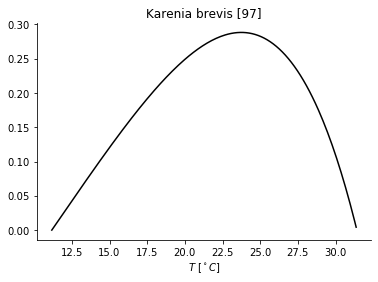

In [128]:
tpc.plot_tpc(s)
print(s['mu.g.opt.val.list'])

In [129]:
median_relative_performance = median_tpc(
    oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.values
) / s['mu.g.opt.val.list']

In [130]:
clim_det = this_det(
    this_region.clim_seas.sel(time=slice(startdate, enddate)).values
) / s['mu.g.opt.val.list']

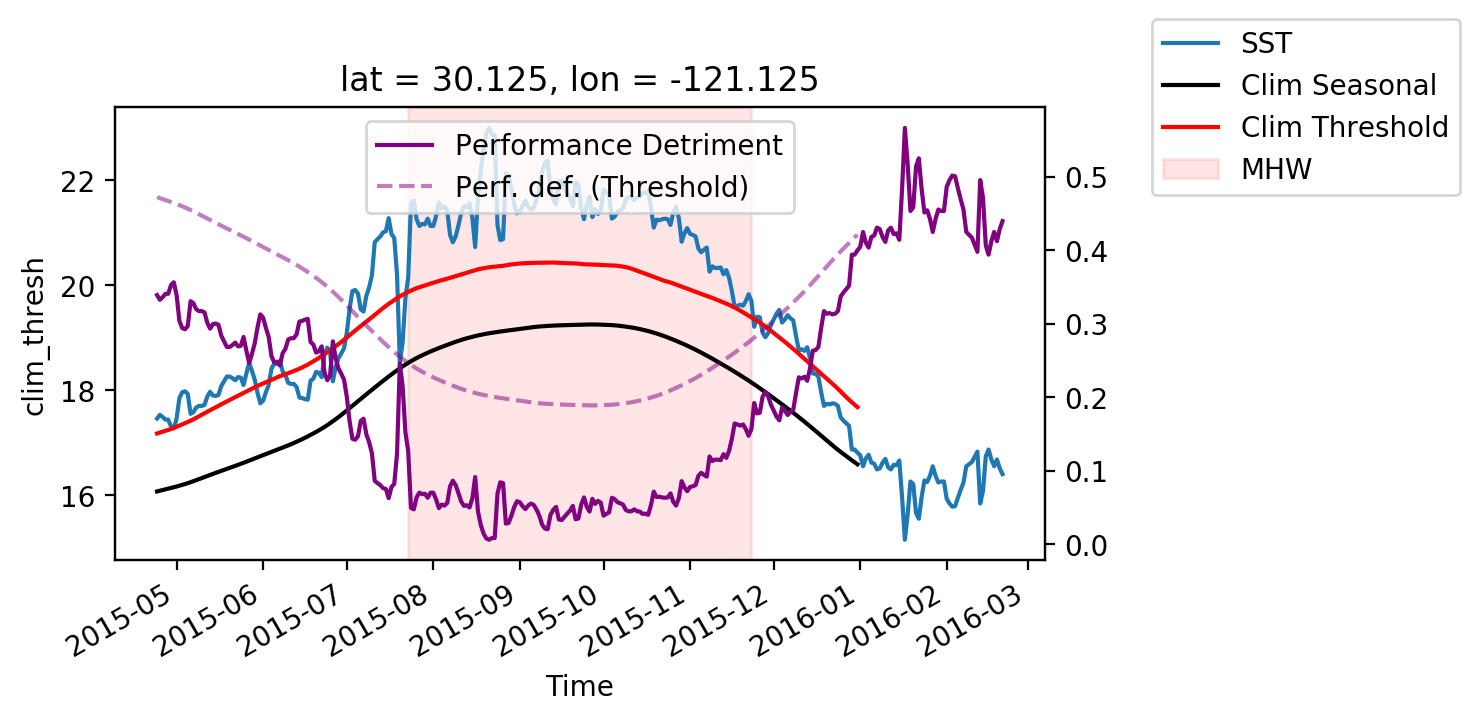

In [135]:
plt.figure(figsize=(6,3), dpi=200)
ax = plt.axes()
# regional_mean_thresh.plot(ax=ax)
# regional_mean_sst.plot(ax=ax)
oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.plot(ax=ax, label='SST')
this_region.clim_seas.sel(time=slice(startdate, enddate)).plot(label='Clim Seasonal', color='k')
this_region.clim_thresh.sel(time=slice(startdate, enddate)).plot(label='Clim Threshold', color='r')


ax1 = ax.twinx()

ax.axvspan(startdate_actual.values, enddate_actual.values, alpha=0.1, color='red', label='MHW')


ax1.plot(oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.time, det_loc, color='purple', label='Performance Detriment')
ax1.plot(this_region.clim_seas.sel(time=slice(startdate, enddate)).time, clim_det, linestyle='--', alpha=0.5, color='purple', label='Perf. def. (Threshold)')
# ax1.set_ylim([0, 0])
ax.legend(loc='center left', bbox_to_anchor=(1.10, 1))
ax1.legend()

## Across Region

In [136]:
region = {
    'lon' : slice(-138., -132.),
    'lat' : slice(42., 48.),
     'time':slice(startdate, enddate)

}

In [137]:
sst_region_mean = oisst_pnw.sel(**region).mean(['lat', 'lon'])
mhw_region_mean = mhw_pnw.sel(**region).mean(['lat', 'lon'])

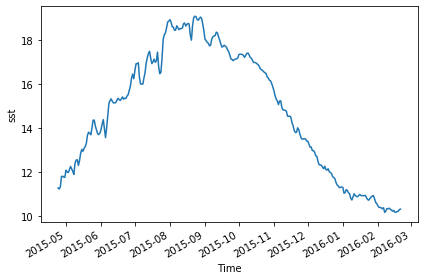

In [138]:

sst_region_mean.sst.plot()
# ax.gridlines(draw_labels=True)
# ax.set_title(f"Max ")
plt.tight_layout()

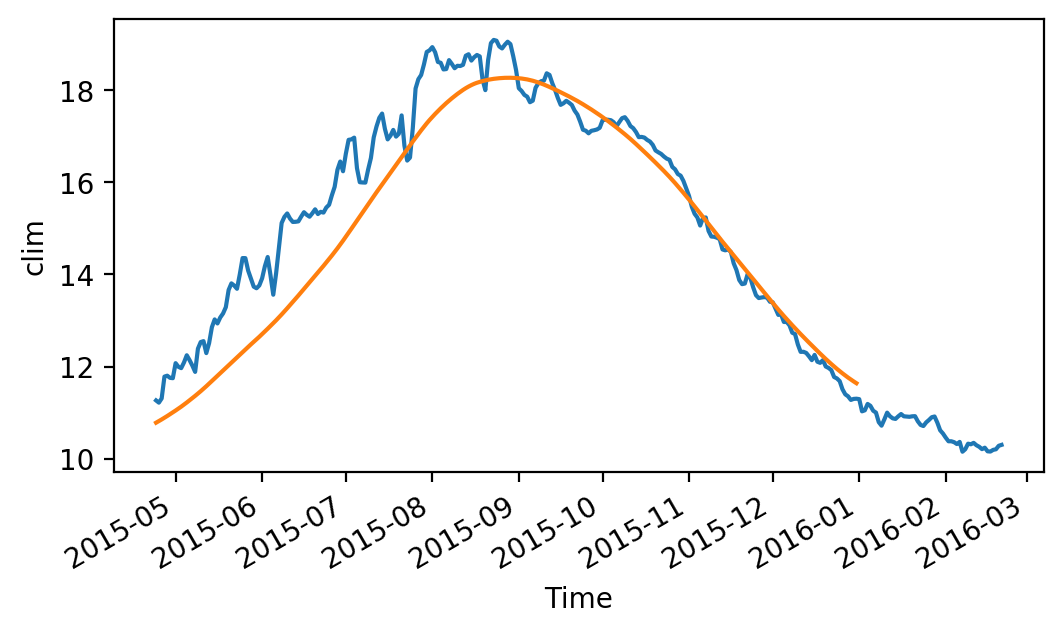

In [85]:
plt.figure(figsize=(6,3), dpi=200)
ax = plt.axes()
# regional_mean_thresh.plot(ax=ax)
# regional_mean_sst.plot(ax=ax)
sst_region_mean.sst.plot(ax=ax, label='SST')
mhw_region_mean.clim.plot(label='Clim. 90% Threshold' ,ax=ax)

# ax1 = ax.twinx()

# ax.axvspan(startdate_actual.values, enddate_actual.values, alpha=0.1, color='red', label='MHW')


# ax1.plot(oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.time, det_loc, color='purple', label='Performance Detriment')
# # ax1.plot(this_region.clim.sel(time=slice(startdate, enddate)).time, clim_det, linestyle='--', alpha=0.5, label='Perf. def. (Threshold)')
# # ax1.set_ylim([0, 0])
# ax.legend(loc='center left', bbox_to_anchor=(1.10, 1))
# ax1.legend()